# Snapchat Political Ads
* **After basic data cleaning, exploration, we can raise more questions on the data set**
* See data_cleaning.ipynb for information on the more primitive dataframes.
* A few example prediction questions to pursue are:
    * Predict the reach (number of views) of an ad.
    * Predict how much was spent on an ad.
    * Predict the target group of an ad. (For example, predict the target gender.)
    * Predict the (type of) organization/advertiser behind an ad.


# Summary of Findings


### Introduction
We are going to continue using the snapchat political ads data from `data_cleaning.ipynb`. We combined the data of 2018 and data of 2019. At the first glimpse, the data set does not contains many numeric columns: it has over 30 columns, yet it really has two quantitative variables before cleaning: the `Spend` column, and the `Impression` columns. Before writing any codes or doing any further investigation, we think that there is a relationship between its columns, for example, the amount (In local currency) spent by the advertiser over the campaign (up to the current date), and the number of times the Ad has been viewed by Snapchatters.
    
Spend would be a good dependent variable X and when impression is the dependent variable Y, what we try to predict. Because to think about it, the goal of these advertisement is to persuade more people to vote or pay attention to some campaigns, and it is quite important, and to the benefit of the compaign, to make more impressions. To make snapchat put their ads longer, or to recommend the ads to more people, the companies or organization should pay more. Think about Mike Bloomberg, the American business man who ran for the president in 2020. He spent around 300 million US dollars in his compaign. As a result, he is often seen on the ads on all the platform. (Ask a friend if he/she has saw Mike Bloomberg in an ads before). Besides spend, we will include more features to help predict the Impression, such as gender, region, age... etc. 
    
It would be useful for these organization to decide how many to spend in order to meet their goal of impressions. We will make such model to predict the `impression (target variable)`. Since the number of impression is a numberic, it is not a classfication problem, but a regression problem. The `evaluation metric` we can use for this regression model will be mainly `R²` or sometimes Coefficient of Determination, and Root-Mean-Squared-Error(RMSE).

### Baseline Model

The number of features: 2

We will use spend and gender as features to predict impressions. `Spend`, is said above, a quantitative variable, and `Gender` is nomial: even though it only has male, female, and both as the unique values, the values have no order.

For spend, we choose it because spend and impression has a correlational coefficient of 0.84, a strong indication of correlation. Then we put the gender columns in a function transformer in the column transformer. We keep the original spend, and we `one hot encode` gender. At this point, we have a simple linear regression pipeline. 

For that regression model, we will try different scaling transformation, and we will compare the R^2 value and the RMSE for each model. We plot spend against impressions, and since there are many outliers and the range is big, we cannot see the clear relationship. We assume that it is linear because of correlational coefficient value, but we did the following investigation:

If we directly use linear relationship (keep spend whatever it is), we have an average R2 score of 0.433 in 100 predictions, using square root trasformation of regression, we have an average of R2 score of 0.356 in 100 predictions. If we use log transformation, we have an average of R2 score of 0.102 in 100 predictions. They are all bad in our opinion, but it seems like keep spend as what it is works best for the model.

The RSME is quite big for the model, because the impressions are huge numbers and any deviation from the predicted value can cause a large RSME. Its average has RSME 2988730.

### Final Model

Since our baseline model has only a prediction of 0.433, we carefully explored all the other columns and check for the possibility of more data cleaning. For example, Since we have already have `Duration` from our basic data cleaning process, we do not need `StartDate` and `EndDate`. We only do not need the nomial columns that are too unique in its values, such as the `ADID`, `CreativeUrl`, `BillingAddress`, `CreativeProperties`, they have no use in machine learning process and one hot encoding them will produce as many columns as how many rows we have now.

    change #1: dropping the above columns

    change #2: We realize the spend are not all in USD currency, some of them has different currency so that we cannot use them along with the most USD. 
    
We did some google search: We know that currency values differ each year, the USD to EUR ratio changes all the time. However, it does not matter not much in this calculation, because the currency convertion ratio from January to Feburary might be even higher than the ratio from 2018 to 2019. Therefore there is no need to figure out the exact ratio for that year. We also do not know whether that payment is made at exactly its StartDate, or its EndDate. Therefore the exact value of spend could not be known, yet we can estimate it by finding all the ratios of the median from 2018, and 2019 currency data.

We explored `Organization Name`, `candidate ballot information`, and `paying advertisementname` to evaluate if they are good features to use. Candidate ballot information, along with other columns that we investigated further, has too many null values and it is useless for the model. Therefore, we will exlude them from the model

Then we explore `age`, and we soon realize that it is too much a mess to extract any features. However, instead of using age as a numberic variable, we can use it as an ordinal feature, and one hot encoded it. We mapped all the age into two features/columns: the low bound/limit, the upper bound. For example, if an ad is designed for people who are older than 28, the low bound will be 2 and the upper bound will just be null.

    Change #3: Remove outliers. 

We did a EDA on spend, after we map it correctly on the corresponding currency. It has too many outliers. Some company spend too much then others, and most company don't spend that much. In fact, if we look at the scatter plot, the easily observable outliers are the extreme spenders. We use 1.5 * IQR, the standard removing outlier approach in statistics, to find the boundaries for the spend we will keep.

Here are some more findings as we try different new models with different features:

1. Random forest regressors is a better `model type` than linear regression
2. It is better to remove CreativeUrl, creativeproperties, and genders as features, they seem to add more noise than helping the prediction.
3. Max_depth = 30, min_samples_split=15, min_samples_leaf=2, are the `best paramaters` we found for randomforestregressor, which is better than linear regressor.

The `features` we added on the baseline model along with the changes, and why are they good for the data set / our model:

1. `Country code`, one hot encoded. The number of impressions can depend on which country the ads is shown to. This can be determined by many factors such as the percentage of active snapchat users in different country... etc.
2. `Age's lower boundary`, one hot encoded. This categorize the data into different age targets. Ads that do not have lower or upper boundary / ads that is suitable for all viewers might have higher view.
3. `Age's upper boundary`, one hot encoded. Same reason as above, it can be quite influential because it select only a part of the viewers to gain impression.
4. `Duration`, standard scaled. It can be useful for the prediction, because the longer the duration is, the more impressions the ads can have. There should be a linear, positive relationship between duration and impressions.

### Fairness Evaluation

If we scatter plot spending vs impressions, we realize that we get a "fan" shape distribution. Therefore we ask: is the model fair on companies or organizations that spend less, or the companies or organizations that spend more? 

We find 250 to be a good cut to binarize spend, because number of spends less than that and spends more than are rougly equal. They have an observed difference in prediction score: around 3%, is that due to random chance, or they are siginifantly different? We will perform a permutation test:

    Null hypothesis: population of ads that spend less, and population of ads that spend more, have same prediction score on impression.

    Alternative hypothesis: population of ads that spend less, have better prediction score on impression than the population of ads that spend more.

The permutation test randomized shuffle the data so the cheap group and expensive group are randomized every time, not actually depend on their amount of spending. It turns out that it is normal to get a prediction acurracy difference 3%, because the p value is 0.55. We don't reject the null, it seems that the prediction is fair for both cheap and expensive ads population.

The `parity measure` we use is the difference in their `R^2 score`, or the pl.score(X) value.

The second permutation test we did is to see if for different bins/groups of impressions, the predictions for impression are same. We will split the impressions into 5 groups and check the metric accuracy score.

    The null hypothesis is that these group have same predictions. The total variable distance of predictions R^2 scores of the dataframe binned by different impressions, is the same if we randomized the dataframe into 5 random groups. The difference of predictions of each bins just happened by chance.

    Alternative hypothesis is that these group have different predictions and they have a greater total variable distance of predictions R^2 scores among different bins of impressions.

We will use the significance level of 0.05. In the permutation test, we shuffle the impression column to group them randomly and differently everytime, while keep track of the total variable distance of predictions R^2 scores among different bins of impressions. 

The result is that the p value is 0.11. We do not reject the null hythesis, because 0.11 is greater than our significant level threshold of 0.05. The observed variations between the R^2 prediction scores of the impressions of different bins, grouped by the pd.qcut function, is random, and not due to significant difference.

We can conclude that the model is fair on different amount of impressions.

# Code

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import svm

import statsmodels.api as sm
import sklearn as sk
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from sklearn.svm import LinearSVR
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

# Load/Clean Data

We downloaded both dataset from https://www.snap.com/en-US/political-ads/will to datahub and import both datasets below.(For both 2018 and 2019) We noticed that there are many columns for each data set and in order to minimize confusion, we will use the readme.txt given by Snapchat to understand what each column means. 

In [75]:
a18 = pd.read_csv('pa2018.csv')
a19 = pd.read_csv('pa2019.csv')
rms = open('readme.txt').readlines()
rms = [r for r in rms if r != '\n']
rd = {}
rms = rms[3:-1]
for r in rms:
    sps = r.split(' - ')
    rd[sps[0]] = sps[1][:-1]
#rd is the column description dictionary that we can use later.
#for example, check the third column, 'spend' from readme.txt
rd[a19.columns[3]]
rd

{'AD ID': 'Unique identifier for each Political Ad.',
 'CreativeURL': 'URL link to creative content for the Ad.',
 'Currency Code': 'The currency code set for the Ad Account and Ad.',
 'Spend': 'Amount (In local currency) spent by the advertiser over the campaign (up to the current date).',
 'Impressions': 'Number of times the Ad has been viewed by Snapchatters.',
 'Start Date': 'The time at which the Ad was set up to start delivering.',
 'End Date': 'The time at which the Ad was set up to stop delivering.',
 'Organization Name': 'The name of the Organization within Ads Manager who is responsible for creating the Ad.',
 'BillingAddress': 'The address of the Organization within Ads Manager who is responsible for creating the Ad.',
 'CandidateBallotInformation': 'The name of the candidate/ ballot initiative associated with the Ad.',
 'PayingAdvertiserName': 'Name of the entity providing the funds for the Ad. This is the name we will display within the Snapchat app within our "Paid for by

Fill missing date time. Reason: missing date time most likely mean the ad has not finished

In [76]:
a18['EndDate'] = a18.EndDate.fillna('2018/12/31 23:59:59Z')
a19['EndDate'] = a19.EndDate.fillna('2019/12/31 23:59:59Z')

  Concatenate the 2018 CSV and the 2019 CSV into one DataFrame so that we have data from both years. Check if the concatination is successful by looking at its dimensions. Save the dataFrame as a new variable called `ads`

In [77]:
ads = pd.concat([a18, a19])

Z at the end of the StartDate and EndDate stand for zulu timezone, which is UTC. The data is uniform: all the times end on 'Z'. We will convert these time to pandas timestamp. Directly converting the time will be ok because they are all the in same timezone.

We will calculate the duration of the time when each ads was up and assign it to a new column called `Duration`

In [78]:
ads.StartDate.apply(lambda x: x[-1]).unique(), ads.EndDate.dropna().apply(lambda x: x[-1]).unique()
ads = ads.astype({'StartDate':'datetime64', 'EndDate':'datetime64'})
ads = ads.assign(Duration = ads.EndDate - ads.StartDate)
ads.Duration

0        5 days 05:59:11
1        0 days 06:57:48
2       29 days 14:59:00
3        5 days 23:59:23
4        4 days 01:54:33
              ...       
3604     5 days 09:13:02
3605   103 days 03:16:38
3606    20 days 05:59:51
3607    27 days 02:32:00
3608     9 days 00:00:00
Name: Duration, Length: 4268, dtype: timedelta64[ns]

In [79]:
#ads.any()[ads.any() == False]

Electoral Districts (Excluded), Targeting Connection Type, and Targeting Carrier (ISP) are columns that has all null values as keys. Therefore we will drop these 3 columns, which are for simplier analysis. 

In [80]:
print('Electoral Districts (Excluded): '+ rd['Electoral Districts (Excluded)'])
print('Target Connection Type: ' + rd['Target Connection Type'])
print('Targeting Carrier (ISP): ' + rd['Targeting Carrier (ISP)'])

Electoral Districts (Excluded): Electoral district(s) excluded targeting criteria used in the Ad. When this field is populated Ad impressions will be delivered outside the excluded Electoral district(s).
Target Connection Type: Internet connection type targeting criteria used in the Ad. If empty, then no internet connect type targeting was used.
Targeting Carrier (ISP): Carrier type targeting criteria used in the Ad. If empty, then is it targeting all carrier types.


Based on the data description, we decided that it is safe to assume that Electoral Districts (Excluded) has no use for this analysis, no internet connect type targeting was used for targeting connection type, and Targeting Carrier (ISP) is targeting all carrier types. We will remove these columns from the dataset.

In [81]:
ads = ads.drop((ads.any()[ads.any() == False]).index, axis = 1)
ads.shape

(4268, 32)

# Baseline Model

Since we are trying to predict Impressions, we will need to find quantitative columns data that are related to impressions. Do a simple EDA by checking the dtypes of the data frame.

We will make a new dataframe called spa stands for snapchat politcal ads, and this dataframe is specifically used for machine learning

In [82]:
spa = ads.copy().reset_index()

In [83]:
ads.dtypes

ADID                                       object
CreativeUrl                                object
Currency Code                              object
Spend                                       int64
Impressions                                 int64
StartDate                          datetime64[ns]
EndDate                            datetime64[ns]
OrganizationName                           object
BillingAddress                             object
CandidateBallotInformation                 object
PayingAdvertiserName                       object
Gender                                     object
AgeBracket                                 object
CountryCode                                object
Regions (Included)                         object
Regions (Excluded)                         object
Electoral Districts (Included)             object
Radius Targeting (Included)                object
Radius Targeting (Excluded)                object
Metros (Included)                          object


This data set does not seem to have many quantitative data, which is important in our regressive prediction. We will take spend because it is important for this predictions. The more moeny each add spends, the more impressions it should get. In fact, it has a quite good corrcoef value

In [84]:
np.corrcoef(spa.Spend, spa.Impressions)[0][1]

0.8422988483906694

Will gender plays a role in the impression? We do not try know the answer in "does women view more ads than men in snapchat", but we will add that into our model because some ads that specially target women and the ads that specially target men might have some difference in their nature so that it can be a factor in impressions

The function `explore` allows us to check the number of unique values, and the value counts for a column in spa. We will first use this function on gender

In [85]:
def explore(col):
    return ('Number of unique values: '+ str(len(spa[col].unique())), spa[col].value_counts())

In [86]:
explore('Gender')

('Number of unique values: 3', FEMALE    293
 MALE       92
 Name: Gender, dtype: int64)

Create the necessary function transformer of gender column. We one hot encode the gender columns, so we can extract the feature of this columns

In [87]:
def gender_func(df):
    srs = df.Gender
    def map_gender(x):
        if pd.isna(x): 
            return "Both"
        return x
    return OneHotEncoder().fit_transform(srs.apply(map_gender).to_frame())

### Build a simple linear regression model

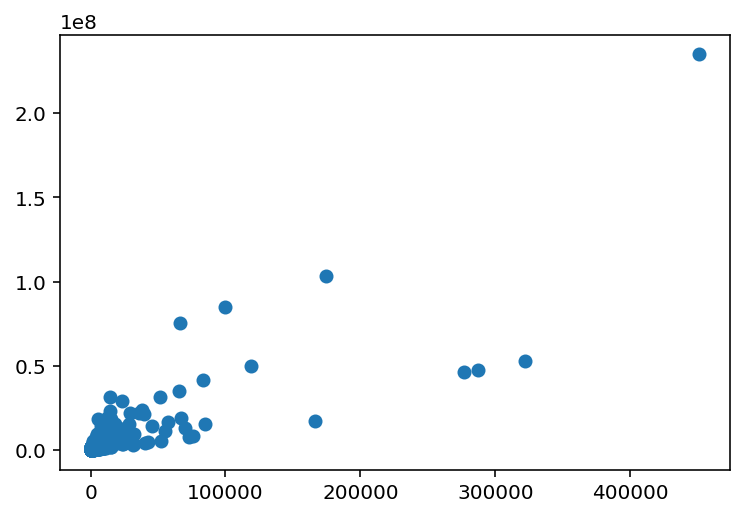

In [88]:
plt.scatter(spa.Spend, spa.Impressions)

The plot looks quite linear, but we will make three models, use different functiontransformer on spend column every time.

    1. Directly using linear relationship

In [89]:
def linear(x):
    preproc = ColumnTransformer(transformers=[('Spend', FunctionTransformer(lambda x: x), ['Spend']), 
                                          ('gender', FunctionTransformer(gender_func), ['Gender'])])
    pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', LinearRegression())]) 
    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)



pd.Series(range(100)).apply(linear).mean()

0.43267525194611617

    2. Using Square root transformation

In [90]:
def sqrte(x):
    preproc = ColumnTransformer(transformers=[('Spend', FunctionTransformer(lambda x: np.sqrt(x)), ['Spend']), 
                                              ('gender', FunctionTransformer(gender_func), ['Gender'])])
    pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', LinearRegression())]) 
    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)

pd.Series(range(100)).apply(sqrte).mean()

0.35682478322706696

    3. Using Log transformation

In [91]:
(spa.Spend == 0).sum()

73

In [92]:
def log_model(x):
    def logg(df):
        def loggg(num):
            if num == 0:
                return 0.01
            return np.log(num)
        return df.Spend.apply(loggg).to_frame()
    preproc = ColumnTransformer(transformers=[('Spend', FunctionTransformer(logg), ['Spend']), 
                                              ('gender', FunctionTransformer(gender_func), ['Gender'])])
    pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', LinearRegression())]) 
    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)

pd.Series(range(100)).apply(log_model).mean()

0.10219447674650754

By simply comparing the $R^2$ of both models, (average of 100 trials for each) we realize that linear model is the best among too. Which makes sense because of the plot. Our distribution looks like a fan, so it is more likely to have a linear relationship.

### The model we choose for base line model

#### Find R2 and RMSE

In [93]:
def baseline_model():
    preproc = ColumnTransformer(transformers=[('Spend', FunctionTransformer(lambda x: x), ['Spend']), 
                                          ('gender', FunctionTransformer(gender_func), ['Gender'])])
    pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', LinearRegression())]) 
    X = spa.drop('Impressions', axis=1)
    y = StandardScaler().fit_transform(pd.DataFrame(spa.Impressions))
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)

bl_results = pd.Series(range(1000)).apply(lambda x: baseline_model())

In [94]:
bl_results.mean()

0.42973582068969546

In [95]:
def baseline_model_2():
    preproc = ColumnTransformer(transformers=[('Spend', FunctionTransformer(lambda x: x), ['Spend']), 
                                          ('gender', FunctionTransformer(gender_func), ['Gender'])])
    pl = Pipeline(steps=[('preprocessor', preproc), ('regressor', LinearRegression())]) 
    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl.fit(X_tr, y_tr)
    return np.sqrt(np.mean((pl.predict(X_ts) - y_ts)**2))

bl_rmse_results = pd.Series(range(1000)).apply(lambda x: baseline_model_2())

In [96]:
bl_rmse_results.mean()

2988730.2868532543

Our RMSE is too large!

# Final Model Model

### Columns Selection

We need to carefully go through all the columns in order to select useful columns for machine learning. There are over 30 columns, although at the first galance, it only have 1 quantative columns, we can extract more features from the table,

We will temporarily remove all the columns that we arbitrarily decided little use or no use to the prediction we will have.
For example, Since we have already get `Duration`, we probabiliy do not need `StartDate` and `EndDate`. 

We do not need the nomial columns that are too unique, such as the `ADID`, `CreativeUrl`, `BillingAddress`, `CreativeProperties`, they have no use in machine learning process and one hot encoding them will produce as many columns as how many rows we have now.



In [97]:
spa = spa.drop(['StartDate', 'EndDate', 'ADID', 'CreativeUrl', 'BillingAddress', 'CreativeProperties'], axis=1)

## More Columns Exploration / Feature Extractions

Now we have printed the first row of the dataframe above, with all the columns that can be potential features we can use for ML. We will explore these columns one by one, and once we figure out how to turn these columns into useful quantitative or hot-coded features, we can make wrap these functions with column transformation for baseline model

In [98]:
spa.iloc[0]

index                                                    0
Currency Code                                          USD
Spend                                                  343
Impressions                                         111587
OrganizationName                     Blueprint Interactive
CandidateBallotInformation                             NaN
PayingAdvertiserName              Planned Parenthood Votes
Gender                                              FEMALE
AgeBracket                                           18-34
CountryCode                                  united states
Regions (Included)                  Florida,Georgia,Nevada
Regions (Excluded)                                     NaN
Electoral Districts (Included)                         NaN
Radius Targeting (Included)                            NaN
Radius Targeting (Excluded)                            NaN
Metros (Included)                                      NaN
Metros (Excluded)                                      N

    Explore currency code and spend

In [99]:
explore('Currency Code')

('Number of unique values: 5', USD    2532
 EUR     708
 GBP     588
 CAD     400
 AUD      40
 Name: Currency Code, dtype: int64)

It looks like we do not have just USD. We need to convert the currency to USD, the most frequent value

We need to do some google to find out.

(We know that currency values differ each year, the USD to EUR ratio changes all the time. However, it does not matter not much in this calculation, because the currency convertion ratio from January to Feburary might be even higher than the ratio from 2018 to 2019. Therefore there is no need to figure out the exact ratio for that year. We also do not know whether that payment is made at its StartDate, or its EndDate. Therefore the exact value of spend could not be known, yet we can estimate it by finding all the ratios of the median from 2018, and 2019 currency data)

In [100]:
#average of currency convertion of 2018 and 2019, 
#1 eur => 1.15 usd
currency = {
    'EUR': 1.15,
    'GBP': 1.3,
    'CAD': 1.3,
    'AUD': 0.73,
    'USD': 1
}

def current_convertion(row):
    row['Spend'] = row['Spend'] * currency[row['Currency Code']]
    return row

spa = spa.apply(lambda x: current_convertion(x), axis=1).drop('Currency Code', axis=1)

In [101]:
np.corrcoef(spa.Spend, spa.Impressions)[0][1]

0.8460687978739078

There is an slight increase in the corrcoef of these two variables!

In [102]:
spa.head(1)

,index,Spend,Impressions,OrganizationName,CandidateBallotInformation,PayingAdvertiserName,Gender,AgeBracket,CountryCode,Regions (Included),...,Postal Codes (Included),Postal Codes (Excluded),Location Categories (Included),Location Categories (Excluded),Interests,OsType,Segments,Language,AdvancedDemographics,Duration
0,0,343.0,111587,Blueprint Interactive,NaN,Planned Parenthood Votes,FEMALE,18-34,united states,"Florida,Georgia,Nevada",...,NaN,NaN,NaN,NaN,NaN,NaN,Provided by Advertiser,en,NaN,5 days 05:59:11


    explore Organization Name, candidate ballot information, and paying advertisementname

In [103]:
explore('OrganizationName')

('Number of unique values: 365',
 UnRestrict Minnesota                                     311
 Blueprint Interactive                                    248
 The Aber Group                                           223
 ACRONYM                                                  182
 HOPE not hate Charitable Trust                           173
                                                         ... 
 Choice Creative Solutions                                  1
 Only American Pride                                        1
 AGENCE NATIONALE DE PREVENTION ET DE FORMATION (ANPF)      1
 Curious Minds Media Ltd Pty                                1
 Australian Labor Party National Secretariat                1
 Name: OrganizationName, Length: 365, dtype: int64)

In [104]:
explore('CandidateBallotInformation')

('Number of unique values: 72', General Election            121
 Warren for President        116
 Get out the vote             92
 Register to Vote             29
 Liberal Democrats            19
                            ... 
 Marionna Schlatter            1
 Kelley Singleton              1
 Flowers for Sheriff           1
 UK General Election           1
 Mike Bloomberg 2020 Inc       1
 Name: CandidateBallotInformation, Length: 71, dtype: int64)

In [105]:
explore('PayingAdvertiserName')

('Number of unique values: 446', UnRestrict Minnesota              311
 Plan International Canada         210
 HOPE not hate Charitable Trust    173
 Warren for President              150
 ACRONYM                           129
                                  ... 
 Ministère de l'Intérieur            1
 No On L                             1
 Crunch Simply Digital               1
 CoMo/Boone County PHHS              1
 cdH                                 1
 Name: PayingAdvertiserName, Length: 446, dtype: int64)

In [106]:
#spa.PayingAdvertiserName.value_counts().tolist()

When we one hot code these columns, we will not need all of the unique labels because they are so many of them. After we manually print all the unique count, we think it is appropriate to take 50 most frequent labels for OrganizationName, the 7 most frequent labels for CandidateBallotInformation, and 50 most frequent labels for PayingAdvertiserName. 

In [107]:
srs = spa.OrganizationName
value_ct = srs.value_counts()
important = value_ct[:50]
important.sum()

3000

The first 30 values summed up to more than half of the dataframe (which has 4000+ rows), it is not a bad proportion

In [108]:
def map_others(important, x):
    if pd.isna(x):
        return 'Null'
    if x not in important.index:
        return 'Others'
    else:
        return x
from sklearn.preprocessing import OneHotEncoder

In [109]:
def organizationname_func(df):
    srs = df.OrganizationName
    value_ct = srs.value_counts()
    important = value_ct[:50]
    dff = srs.apply(lambda x: map_others(important, x)).to_frame()
    hot = OneHotEncoder().fit_transform(dff)
    return hot

The majority of CandidateBallotInformation is null, shown below, we will drop it

In [110]:
srs = spa.CandidateBallotInformation
value_ct = srs.value_counts()
important = value_ct[:7]
important.sum()

407

In [111]:
spa.CandidateBallotInformation.isnull().sum()

3698

In [112]:
# def candidateballot_func(df):
#     srs = df.CandidateBallotInformation
#     value_ct = srs.value_counts()
#     important = value_ct[:7]
#     dff = pd.Series(srs.to_list()).apply(lambda x: map_others(important, x)).to_frame()
#     hot = OneHotEncoder().fit_transform(dff)
#     return hot

#DROPPED!

In [113]:
spa = spa.drop('CandidateBallotInformation', axis = 1)

In [114]:
srs = spa.PayingAdvertiserName
value_ct = srs.value_counts()
important = value_ct[:50]
important.sum()

2686

In [115]:
def payingad_func(df):
    srs = df.PayingAdvertiserName
    value_ct = srs.value_counts()
    important = value_ct[:50]
    dff = pd.Series(srs.to_list()).apply(lambda x: map_others(important, x)).to_frame()
    hot = OneHotEncoder().fit_transform(dff)
    return hot

So we created two functions: 

`organizationname_func`
        
`payingad_func`

They all take in a parameter df. 

And output a onehotencoder object

We will need these functions in the column transformation

    Explore Age

In [116]:
explore('AgeBracket'), spa.AgeBracket.unique()                                                                                  

(('Number of unique values: 124', 18+      1699
  18-34     257
  18-24     174
  18-40     173
  17+       145
           ... 
  20-21       1
  17-29       1
  25-29       1
  18-27       1
  19-27       1
  Name: AgeBracket, Length: 123, dtype: int64),
 array(['18-34', '18-20', nan, '18+', '18-28', '30+', '25+', '25-', '34-',
        '16-25', '15-24', '17+', '25-29', '18-24', '15+', '29+', '20-29',
        '16-24', '18-26', '18-29', '18-18', '17-25', '18-25', '26+', '30-',
        '20+', '21-25', '18-30', '21-30', '17-24', '19-27', '22+', '15-22',
        '18-23', '19-19', '35++', '20-', '15-34', '24-', '23-', '16-22',
        '18-', '31-34', '15-19', '26-30', '21+', '17-29', '16-', '18-40',
        '21-34', '16+', '14-21', '20-23', '19+', '14-19', '17-', '35+',
        '17-23', '21-45', '25-34', '18-35', '17-40', '35-45', '15-17',
        '17-20', '15-20', '17-35', '16-19', '19-34', '21-24', '18-39',
        '28+', '24-34', '25-27', '19-', '20-24', '15-30', '17-34', '18-19',
      

We think that we might be able to translate age into a quantitative columns first

it turns out that if we just average the lower and upper bound of age, which is turnning it into a number, it is really hard to find what does cases like "17+" belongs to

Therefore, we will make two columns for age, first columns is the lower bound, second column is upper bound. 1 means between 10 - 20 years old, 3 means between 30 - 40 years old, and null means there is no boundry

In [117]:
import re
def change_age(num):
    if '-' in str(num) and str(num)[-1] != '-':
        aa = str(num).split('-')
        return (aa[0][0], aa[1][0])
    elif pd.isna(num):
        return ('null', 'null')
    else:
        if '+' in num:
            return (re.findall('\d+', num)[0][0], 'null')
        else:
            return ('null', re.findall('\d+', num)[0][0])
ages = spa.AgeBracket.apply(change_age)
ages.unique()

array([('1', '3'), ('1', '2'), ('null', 'null'), ('1', 'null'),
       ('3', 'null'), ('2', 'null'), ('null', '2'), ('null', '3'),
       ('2', '2'), ('1', '1'), ('2', '3'), ('null', '1'), ('3', '3'),
       ('1', '4'), ('2', '4'), ('3', '4'), ('null', '4')], dtype=object)

In [118]:
list1, list2 = zip(*ages)
spa = spa.assign(age_lower = list1, age_upper = list2).drop('AgeBracket', axis=1)

    Drop the columns with too many null values

In [119]:
spa.isnull().sum()

index                                0
Spend                                0
Impressions                          0
OrganizationName                     0
PayingAdvertiserName                 0
Gender                            3883
CountryCode                          0
Regions (Included)                3091
Regions (Excluded)                4223
Electoral Districts (Included)    4203
Radius Targeting (Included)       3962
Radius Targeting (Excluded)       4256
Metros (Included)                 4092
Metros (Excluded)                 4251
Postal Codes (Included)           3425
Postal Codes (Excluded)           4151
Location Categories (Included)    4252
Location Categories (Excluded)    4266
Interests                         3174
OsType                            4242
Segments                          1253
Language                          3113
AdvancedDemographics              4159
Duration                             0
age_lower                            0
age_upper                

#explore('Interests')
dropped too because it is too long/unique for each one

explore('Segments')
dropped too because it only has 'provided by advertiser, and the rest are not specified as "not provided by advertiser" from descripton

In [120]:
def duration_change(spa):
    return spa.Duration.apply(lambda x: x.total_seconds()).to_frame()

In [121]:
spa = spa.drop(spa.columns[7:23], axis = 1).drop('index', axis=1)

In [122]:
spa.head(5)

,Spend,Impressions,OrganizationName,PayingAdvertiserName,Gender,CountryCode,Duration,age_lower,age_upper
0,343.0,111587,Blueprint Interactive,Planned Parenthood Votes,FEMALE,united states,5 days 05:59:11,1,3
1,8.0,3924,Research Triangle Student Advocacy,ResTri Student Advocacy,FEMALE,united states,0 days 06:57:48,1,3
2,6.0,2216,"Do Something, Inc.",DoSomething.org,NaN,united states,29 days 14:59:00,1,2
3,317.2,122810,Luton Borough Council,BSBT,NaN,united kingdom,5 days 23:59:23,null,null
4,3698.0,573475,The Prosper Group,No On L,NaN,united states,4 days 01:54:33,1,null


## Predict Impression

In [123]:
def final_model_linearReg():

    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    preproc = ColumnTransformer(transformers=[
            ('Spend', FunctionTransformer(lambda x:x), ['Spend']),
            ('Oga_name', FunctionTransformer(organizationname_func), ['OrganizationName']),
            ('Paying', FunctionTransformer(payingad_func), ['PayingAdvertiserName']),
            ('gendering', FunctionTransformer(gender_func), ['Gender']),
            ('hot country', OneHotEncoder(handle_unknown='ignore'), ['CountryCode']),
            ('age lower', OneHotEncoder(), ['age_lower']),
            ('age upper', OneHotEncoder(), ['age_upper']),
            ])
    pl = Pipeline(steps=[('preprocessor', preproc), 
                         ('regressor', LinearRegression())])
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)


In [124]:
linearReg_result = pd.Series(range(10)).apply(lambda x: final_model_linearReg())

In [125]:
linearReg_result

0    0.739432
1    0.436842
2    0.541698
3    0.386092
4    0.408529
5    0.373198
6    0.422067
7    0.521096
8    0.524623
9    0.362865
dtype: float64

We are getting some very inaccurate predictions. It might happen because of the outliers.

We will remove extreme values of Spend. These values will greatly affect the result of the ML

### EDA

Text(0.5, 1.0, 'Impressions')

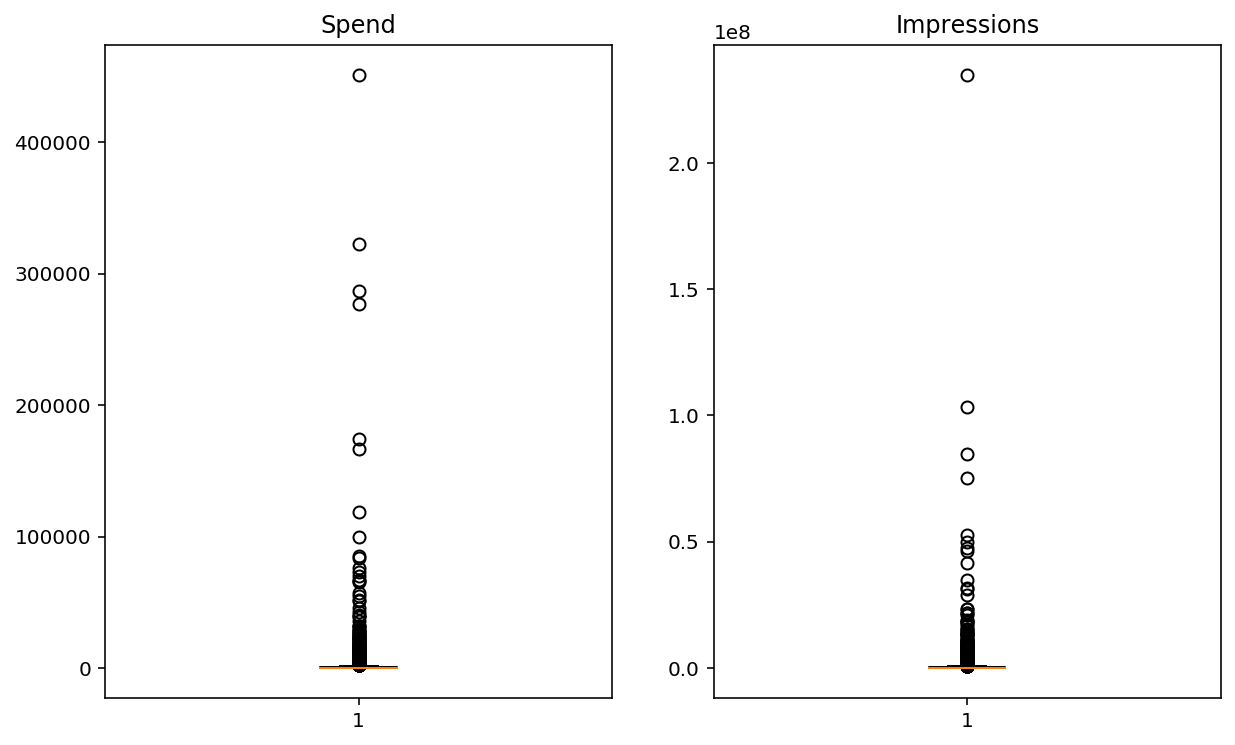

In [126]:
fig, axs = plt.subplots(1,2,figsize=(10,6))

# plot spend
axs[0].boxplot(ads.Spend)
axs[0].set_title('Spend')

# plot Impression
axs[1].boxplot(ads.Impressions)
axs[1].set_title('Impressions')


There are indeed many outliers!

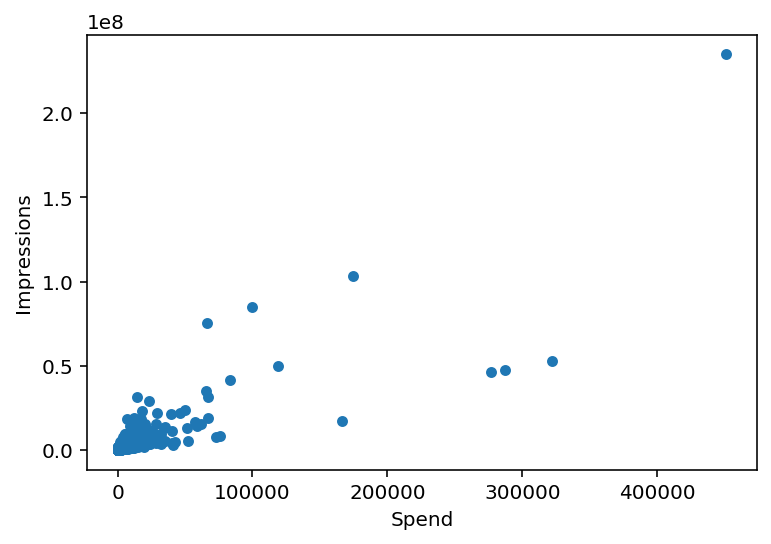

In [127]:
spend = spa.Spend
impressions = spa.Impressions
spa.plot(kind='scatter', x='Spend', y='Impressions');

Getting rid of the outliers will provide us a better picture

In [128]:
spa.Spend.quantile([0.25,0.5,0.75])

0.25     42.00
0.50    205.40
0.75    830.05
Name: Spend, dtype: float64

In [129]:
IQR = 830.05 - 42
spend_upper = 830.05 + IQR * 1.5
spend_lower = 42.00 - IQR * 1.5
spend_upper, spend_lower

(2012.1249999999998, -1140.0749999999998)

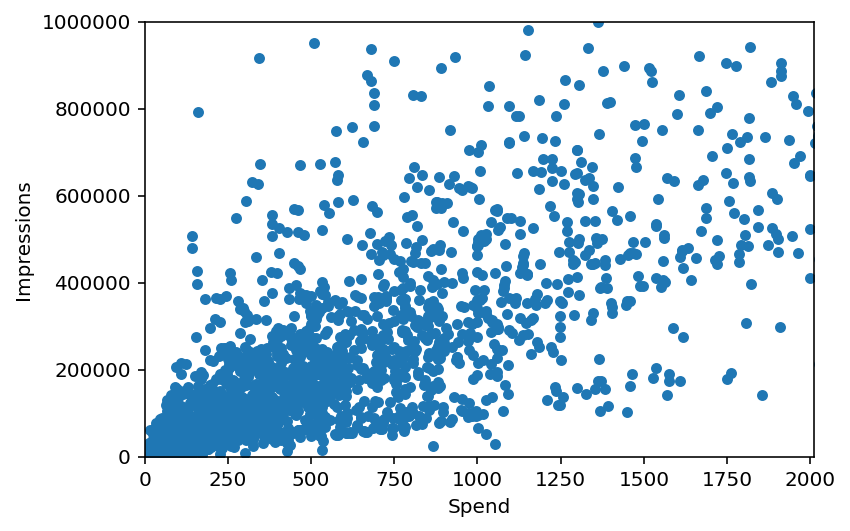

In [130]:
spa.plot(kind='scatter', x='Spend', y='Impressions', xlim=[0, 2012.12499999999] , ylim=[0, 1000000]);

In [131]:
spend_lower = 0 #because it is less than 0

In [132]:
spa = spa[spa.Spend < spend_upper]
spa

,Spend,Impressions,OrganizationName,PayingAdvertiserName,Gender,CountryCode,Duration,age_lower,age_upper
0,343.00,111587,Blueprint Interactive,Planned Parenthood Votes,FEMALE,united states,5 days 05:59:11,1,3
1,8.00,3924,Research Triangle Student Advocacy,ResTri Student Advocacy,FEMALE,united states,0 days 06:57:48,1,3
2,6.00,2216,"Do Something, Inc.",DoSomething.org,NaN,united states,29 days 14:59:00,1,2
3,317.20,122810,Luton Borough Council,BSBT,NaN,united kingdom,5 days 23:59:23,null,null
5,115.00,37149,ACRONYM,Our Lives Our Vote,NaN,united states,0 days 23:59:59,1,2
...,...,...,...,...,...,...,...,...,...
4263,72.45,85654,Mouvement Réformateur,MR - Mouvement Réformateur,NaN,belgium,5 days 09:13:02,1,2
4264,159.00,48710,UnRestrict Minnesota,UnRestrict Minnesota,NaN,united states,103 days 03:16:38,1,null
4265,1618.00,275746,Hiebing,Doctors Without Borders,NaN,united states,20 days 05:59:51,3,null
4266,284.00,77720,Blueprint Interactive,ACT NOW ON CLIMATE,NaN,united states,27 days 02:32:00,1,null


In [133]:
def final_model_linearReg():

    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    preproc = ColumnTransformer(transformers=[
            ('Spend', FunctionTransformer(lambda x:x), ['Spend']),
            ('Oga_name', FunctionTransformer(organizationname_func), ['OrganizationName']),
            ('Paying', FunctionTransformer(payingad_func), ['PayingAdvertiserName']),
            ('gendering', FunctionTransformer(gender_func), ['Gender']),
            ('hot country', OneHotEncoder(handle_unknown='ignore'), ['CountryCode']),
            ('age lower', OneHotEncoder(), ['age_lower']),
            ('age upper', OneHotEncoder(), ['age_upper']),
            ])
    pl = Pipeline(steps=[('preprocessor', preproc), 
                         ('regressor', LinearRegression())])
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)


In [134]:
linearReg_result = pd.Series(range(10)).apply(lambda x: final_model_linearReg())
linearReg_result

0    0.456804
1    0.482120
2    0.440434
3    0.426125
4    0.448143
5    0.454366
6    0.407616
7    0.385779
8    0.453300
9    0.479921
dtype: float64

Now the value looks much better! We do not get as much negative values

In [135]:
linearReg_result.mean()

0.44346082947132925

We probabily do not need that many features, we will remove organization name and paying advertisement

In [136]:
def final_model_improved():

    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    preproc = ColumnTransformer(transformers=[
            ('Spend', FunctionTransformer(lambda x:x), ['Spend']),
            ('gendering', FunctionTransformer(gender_func), ['Gender']),
            ('hot country', OneHotEncoder(handle_unknown='ignore'), ['CountryCode']),
            ('age lower', OneHotEncoder(), ['age_lower']),
            ('age upper', OneHotEncoder(), ['age_upper']),
            ])
    pl = Pipeline(steps=[('preprocessor', preproc), 
                         ('regressor', LinearRegression())])
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)


In [137]:
linearReg_result = pd.Series(range(100)).apply(lambda x: final_model_improved())
linearReg_result

0     0.568275
1     0.575306
2     0.596437
3     0.623627
4     0.531792
        ...   
95    0.581302
96    0.557131
97    0.553630
98    0.600419
99    0.565667
Length: 100, dtype: float64

In [138]:
linearReg_result.mean()

0.579919058188141

Much Better!

We have get rid of many outliers, and we did not use some of the features we created. Let's think if there is something else missing.
Let us explore the Duration column, that we have not use that much

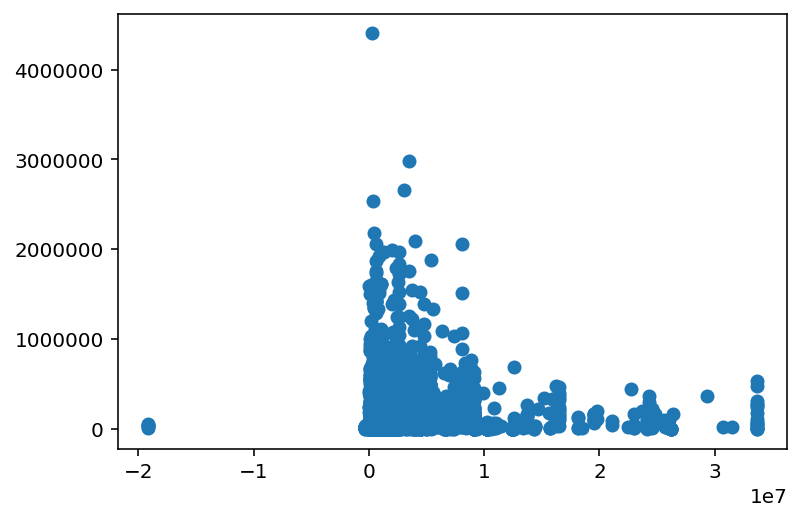

In [139]:
xx = spa.Duration.apply(lambda x: x.total_seconds())
yy = spa.Impressions
plt.scatter(xx, yy)

In [140]:
def helper(x):
    if x < 0: return 0
    return x
spa['Duration'] = spa.Duration.apply(lambda x: x.total_seconds()).apply(helper)

In [141]:
explore('Duration')

('Number of unique values: 1170', 8921002.0    71
 9081498.0    66
 8910998.0    64
 2530393.0    56
 8035199.0    49
              ..
 362848.0      1
 517778.0      1
 1666599.0     1
 777512.0      1
 2465837.0     1
 Name: Duration, Length: 1170, dtype: int64)

In [142]:
spa['Duration'] = StandardScaler().fit_transform(spa[['Duration']])

In [143]:
spa.Duration.isnull().sum()

0

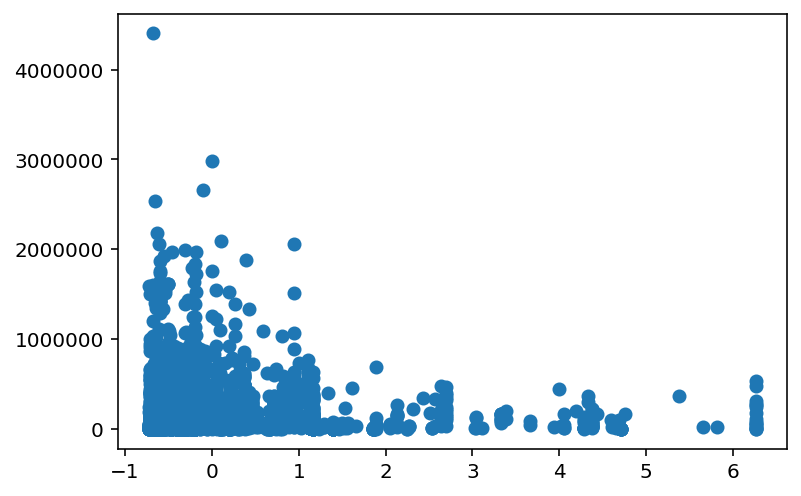

In [144]:
xx = spa.Duration
yy = spa.Impressions
plt.scatter(xx, yy)

Comparing linear regression vs RandomForestRegressor, we realize the random forest regressor have generally better score

In [145]:
def final(k):
    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    preproc = ColumnTransformer(transformers=[
            ('Spend', StandardScaler(), ['Spend']),
            ('hot country', OneHotEncoder(handle_unknown='ignore'), ['CountryCode']),
            ('age lower', OneHotEncoder(), ['age_lower']),
            ('age upper', OneHotEncoder(), ['age_upper']),
            ('Duration', FunctionTransformer(lambda x:x), ['Duration'])
            ])
    pl = Pipeline(steps=[('preprocessor', preproc), 
                         ('regressor', RandomForestRegressor(max_depth = k))])
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)

In [146]:
final(100)

0.677585746399632

# determine paramters

commented because it takes long to run

In [147]:
trials = [2, 10, 15, 18, 20, 25, 30, 40]
rt = []
for i in trials:
    for _ in range(10):
        results = []
        results.append(final(i))
    rt.append(results)

In [148]:
pd.DataFrame(rt, index=trials)

,0
2,0.530987
10,0.666540
15,0.711997
18,0.649269
20,0.626239
25,0.726376
30,0.649517
40,0.645567


In [1013]:
# How many combinations are there to search through?

parameters = {
    'max_depth': [2,10,15,20,30,50,None], 
#     'min_samples_split':[2,7,10,15,20],
#     'min_samples_leaf':[2,7,10,15,20]
}

In [1014]:
clf = GridSearchCV(RandomForestRegressor(), parameters, cv = 5)
X = spa.drop('Impressions', axis=1)
y = spa.Impressions
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
clf.fit(preproc.fit(X_tr).transform(X_tr), y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [1015]:
clf.best_params_

{'max_depth': 30}

In [1016]:
# How many combinations are there to search through?

parameters = {
    'min_samples_split':[2,3,5,7,10,15,20],
}

In [1017]:
clf = GridSearchCV(RandomForestRegressor(), parameters, cv = 5)
X = spa.drop('Impressions', axis=1)
y = spa.Impressions
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
clf.fit(preproc.fit(X_tr).transform(X_tr), y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [1018]:
clf.best_params_ 

{'min_samples_split': 15}

In [1019]:
parameters = {
    'min_samples_leaf':[2,3,5,7,10,15,20]
}

In [1020]:
clf = GridSearchCV(RandomForestRegressor(), parameters, cv = 5)
X = spa.drop('Impressions', axis=1)
y = spa.Impressions
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
clf.fit(preproc.fit(X_tr).transform(X_tr), y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [1021]:
clf.best_params_ 

{'min_samples_leaf': 2}

In [1037]:
def final():
    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    preproc = ColumnTransformer(transformers=[
            ('Spend', StandardScaler(), ['Spend']),
            ('hot country', OneHotEncoder(handle_unknown='ignore'), ['CountryCode']),
            ('age lower', OneHotEncoder(), ['age_lower']),
            ('age upper', OneHotEncoder(), ['age_upper']),
            ('Duration', FunctionTransformer(lambda x:x), ['Duration'])
            ])
    pl = Pipeline(steps=[('preprocessor', preproc), 
                         ('regressor', RandomForestRegressor(max_depth = 30, min_samples_split=15, min_samples_leaf=2))])
    pl.fit(X_tr, y_tr)
    return pl.score(X_ts, y_ts)

In [1051]:
final()

0.7050430081510073

## Fairness Evaluation

Adding the paramater spa dataframe in order to use this model to predict different subset of the spa dataset.

In [149]:
def final(spa):
    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    preproc = ColumnTransformer(transformers=[
            ('Spend', StandardScaler(), ['Spend']),
            ('hot country', OneHotEncoder(handle_unknown='ignore'), ['CountryCode']),
            ('age lower', OneHotEncoder(), ['age_lower']),
            ('age upper', OneHotEncoder(), ['age_upper']),
            ('Duration', FunctionTransformer(lambda x:x), ['Duration'])
            ])
    pl = Pipeline(steps=[('preprocessor', preproc), 
                         ('regressor', RandomForestClassifier(max_depth = 30, min_samples_split=15, min_samples_leaf=2))])
    pl.fit(X, y)
    return pl.score(X, y)

In [151]:
final(spa)

0.7026161238654565

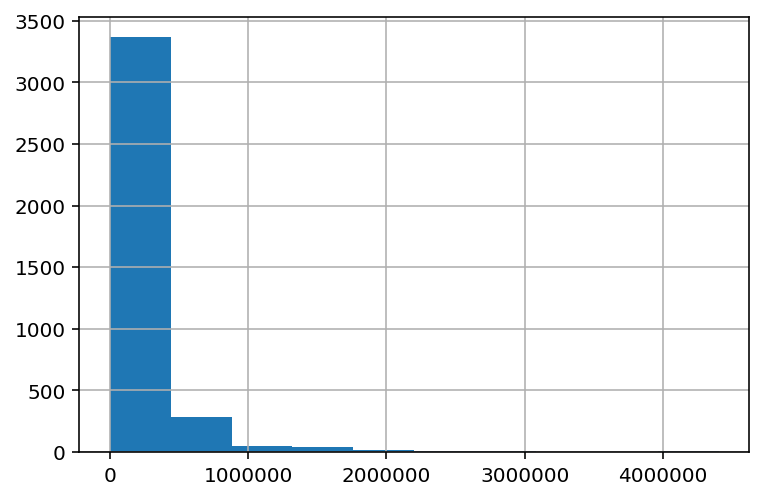

In [67]:
spa.Impressions.hist()

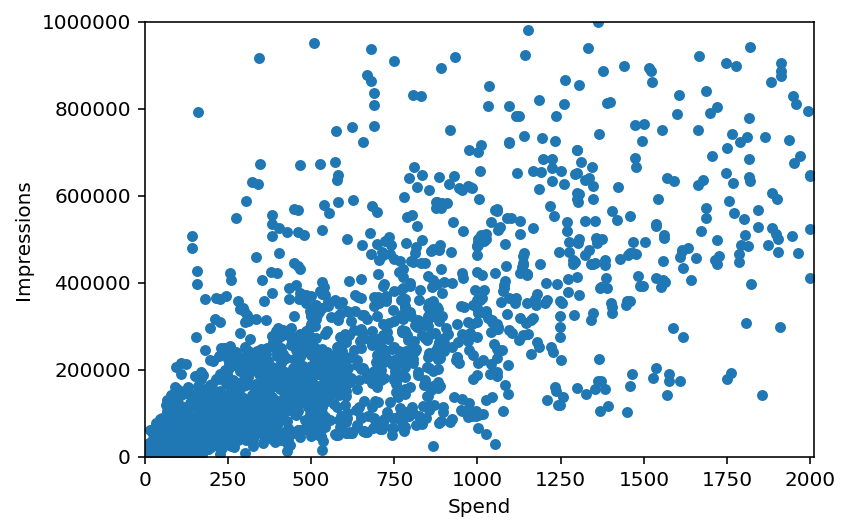

In [79]:
spa.plot(kind='scatter', x='Spend', y='Impressions', xlim=[0, 2012.12499999999] , ylim=[0, 1000000]);

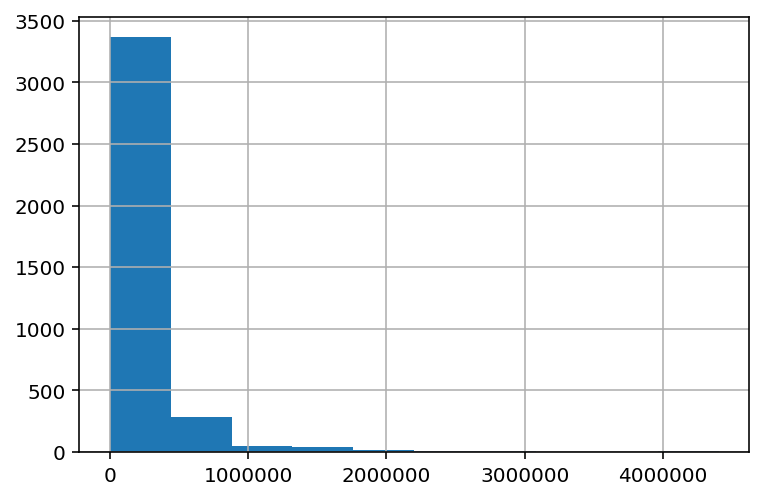

In [69]:
spa.Impressions.hist()

In [81]:
(spa.Spend <= 250).sum()

2256

Since we kind of see a fan shape on the scatter plot of spend against impressions, we assume that there is a lot of deviations from the predicted value for advertisement that spend a lot. Maybe the model is biased.

In [82]:
spa_cheap = spa[spa.Spend <= 250]
spa_expen = spa[spa.Spend > 250]

In [83]:
cheap_prediction = final(spa_cheap)
cheap_prediction

0.7305999901591002

In [84]:
expen_prediction = final(spa_expen)
expen_prediction

0.7033134313975965

The prediction for the cheaper ads are higher than the prediction than the expensive ads in our observed statistics, and that's exactly what we expected. Now we do permutation test to see if this happened just by chance or this shows a statisicaly difference in the two populations.

We will do more permutation test on impressions later, but this is just the first test we do on spend. 

Null hypothesis: population of ads that spend less, and population of ads that spend more, have same prediction score on impression. 

Alternative hypothesis: population of ads that spend less, have better prediction score on impression than the population of ads that spend more

Set significance level to be 0.05

In [85]:
obs = abs(cheap_prediction - expen_prediction)
obs

0.027286558761503654

The observed value, around 0.03 in accuracy, is the difference between our prediction of the "cheap half" of the advertisement, the ads that spend less, and the "more expensive half" of the advertisements, the ads that spend more. 

In [91]:
perms = []
for _ in range(100):
    df = spa.copy()
    df = df.assign(spend_shuffle = df.Spend.sample(frac=1.0, replace=False).reset_index(drop = True))
    df_cheap = df[df.spend_shuffle <= 250]
    df_expen = df[df.spend_shuffle > 250]
    perms.append(abs(final(df_cheap) - final(df_expen)))

In [92]:
perms

[0.05765002777501094,
 0.03136237867022573,
 0.02917604571255472,
 0.025190446449768755,
 0.031155962620979083,
 0.003894742343454438,
 0.014524834811816767,
 0.022778901118466366,
 0.026987104509598292,
 0.02362302752710632,
 0.0026632327391001853,
 0.027544329834291337,
 0.06382095341537575,
 0.0076132571173450625,
 0.005421334496460539,
 0.014489714565622647,
 0.006611030953662667,
 0.04599545025632479,
 0.0017192491721719216,
 0.03146152699753413,
 0.015147562070642162,
 0.06988857389888081,
 0.01033193701016033,
 0.009890256674663922,
 0.04559491383105252,
 0.06784793067901274,
 0.057624282407865546,
 0.0370995496002674,
 0.002838796165806179,
 0.03074478171477002,
 0.024532847847408945,
 0.06284170529241195,
 0.011364507067422758,
 0.007225290269958662,
 0.02843079741223653,
 0.010690462559725833,
 0.017264205416707812,
 0.012023839760613608,
 0.013701630188871494,
 0.07177552193473724,
 0.03989648760827558,
 0.02440857595561574,
 0.035003641284728104,
 0.0027325982493988654,
 0.

0.55


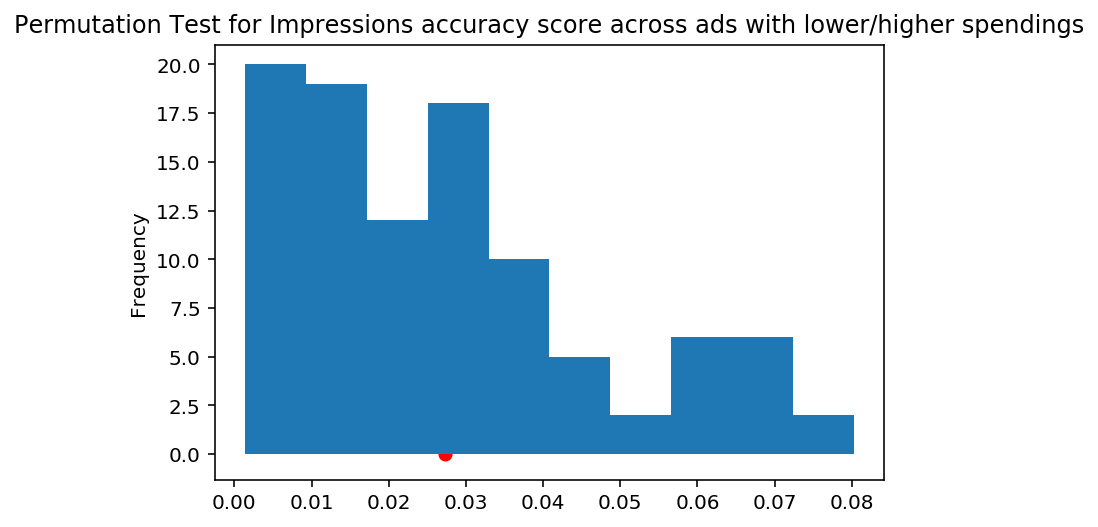

In [93]:
print(pd.Series(perms <= obs).mean())
pd.Series(perms).plot(kind='hist', title='Permutation Test for Impressions accuracy score across ads with lower/higher spendings')
plt.scatter(obs, 0, c='r');

the P value is 0.55. We don't reject the null, it seems that the prediction is fair for both cheap and expensive ads population.

## more permutation test on different bins of y (predicted impression)

Now we will see that if for different bins/groups of impressions, the prediction is same. We will split the impressions into 5 groups and check the metric accuracy score. 

The null hypothesis is that these group have same predictions. The total variable distance of predictions R^2 scores of the dataframe binned by different impressions, is the same if we randomized the dataframe into 5 random groups. The difference of predictions of each bins just happened by chance.

Alternative hypothesis is that these group have different predictions and they have a greater total variable distance of predictions R^2 scores among different bins of impressions.

We will use the significance level of 0.05

In [146]:
def final_predict(spa):
    X = spa.drop('Impressions', axis=1)
    y = spa.Impressions
    preproc = ColumnTransformer(transformers=[
            ('Spend', StandardScaler(), ['Spend']),
            ('hot country', OneHotEncoder(handle_unknown='ignore'), ['CountryCode']),
            ('age lower', OneHotEncoder(), ['age_lower']),
            ('age upper', OneHotEncoder(), ['age_upper']),
            ('Duration', FunctionTransformer(lambda x:x), ['Duration'])
            ])
    pl = Pipeline(steps=[('preprocessor', preproc), 
                         ('regressor', RandomForestClassifier(max_depth = 30, min_samples_split=15, min_samples_leaf=2))])
    pl.fit(X, y)
    return pl.predict(X)

Find the bins from the original impressions

In [162]:
total_score = final(spa)

In [163]:
total_score

0.7090229578216765

Help us get observed value by qcut the impressions into 5 bins

In [153]:
pd.qcut(spa.Impressions, q=5).unique()

[(84461.0, 243604.0], (0.999, 6843.0], (30639.0, 84461.0], (6843.0, 30639.0], (243604.0, 4402020.0]]
Categories (5, interval[float64]): [(0.999, 6843.0] < (6843.0, 30639.0] < (30639.0, 84461.0] < (84461.0, 243604.0] < (243604.0, 4402020.0]]

In [154]:
def map_bin(num):
    if num <= 6843:
        return 'bin1'
    elif num <= 30639:
        return 'bin2'
    elif num <= 84461:
        return 'bin3'
    elif num <= 243604:
        return 'bin4'
    else:
        return 'bin5'

In [155]:
origin_bins = pd.Series(spa.Impressions).apply(map_bin)
origin_bins

0       bin4
1       bin1
2       bin1
3       bin4
5       bin3
        ... 
4263    bin4
4264    bin3
4265    bin5
4266    bin3
4267    bin4
Name: Impressions, Length: 3746, dtype: object

In [182]:
df = spa.assign(bins = origin_bins)
def get_df(df): return df[1]
df_list = list(df.groupby('bins'))
tables = pd.Series(list(map(get_df, df_list)))
diff = []
for i in range(len(tables)):
    diff.append(final(tables[i]))
    print('observed difference of whole table prediction and table ' + str(i + 1) + ' is: ' + str(final(tables[i])))

observed difference of whole table prediction and table 1 is: 0.6653333333333333
observed difference of whole table prediction and table 2 is: 0.7636849132176236
observed difference of whole table prediction and table 3 is: 0.7169559412550067
observed difference of whole table prediction and table 4 is: 0.6929238985313751
observed difference of whole table prediction and table 5 is: 0.6995994659546061


In [202]:
def total_variation_distance(dist1, dist2):
    '''Given two empirical distributions, 
    both sorted with same categories, calculates the TVD'''
    return np.sum(np.abs(dist1 - dist2)) / 2

In [206]:
obs_diff_sum = total_variation_distance(np.array(diff), np.array([total_score]*5))
obs_diff_sum

0.09792758928021966

Permutation test

In [210]:
perms = []
for _ in range(100):
    df = spa.assign(bins = origin_bins.sample(frac=1, replace=False))
    def get_df(df): return df[1]
    df_list = list(df.groupby('bins'))
    tables = pd.Series(list(map(get_df, df_list)))
    diff = []
    for i in range(len(tables)):
        diff.append(final(tables[i]))
    test_statistic = total_variation_distance(np.array(diff), np.array([total_score]*5))
    perms.append(test_statistic)

In [211]:
perms

[0.05929678653224768,
 0.08465415190830466,
 0.09933238955850493,
 0.08858624526597841,
 0.11735642160122856,
 0.08665860228658678,
 0.0719768043337608,
 0.08934040023941281,
 0.07981695900638475,
 0.08065682213527398,
 0.10993559996112756,
 0.060476505067799946,
 0.09132437887759703,
 0.09459870632516848,
 0.09801240736001798,
 0.04528165524608835,
 0.0918276399142619,
 0.09651121801840074,
 0.08315830302062593,
 0.08866483281618182,
 0.08524668140305003,
 0.06056221322325478,
 0.08591334806971668,
 0.07716809385284668,
 0.06864080077345819,
 0.10458624526597843,
 0.07923867072214225,
 0.07857200405547549,
 0.06330301706184271,
 0.06857289413113193,
 0.0839151282210297,
 0.07122887988992149,
 0.0539687936528529,
 0.0752297699655779,
 0.09524579132739369,
 0.08391423814537319,
 0.0572807651704319,
 0.10785345210829833,
 0.08182051930901046,
 0.08190266716183964,
 0.07257200405547554,
 0.07455865292062908,
 0.06990266716183952,
 0.09667640379971548,
 0.07182407961163628,
 0.094676403799

0.11


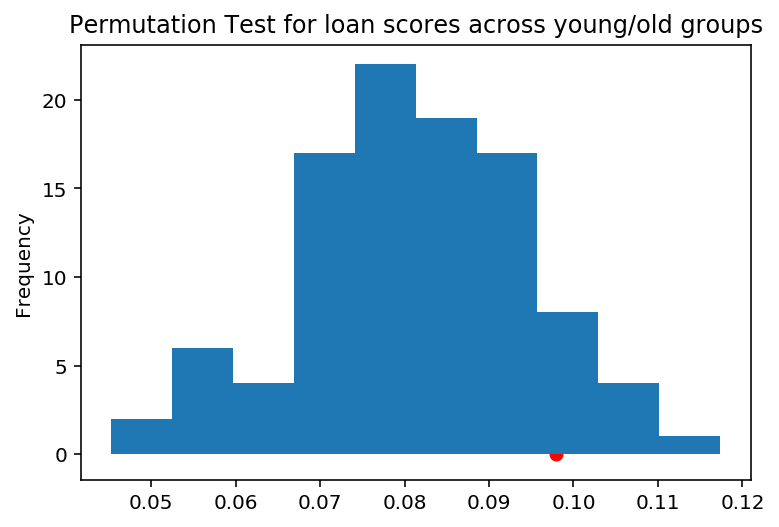

In [212]:
print(pd.Series(perms >= obs_diff_sum).mean())
pd.Series(perms).plot(kind='hist', title='Permutation Test for loan scores across young/old groups')
plt.scatter(obs_diff_sum, 0, c='r');

Therefore we do not reject the null hythesis, because 0.11 is greater than our significant level threshold of 0.05.  The variations between the R^2 prediction scores of the impressions of different bins, grouped by the pd.qcut function, is random, and not due to significant difference. 

We can conclude that the model is fair on different amount of impressions. 